<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_4/19_Discovering_Kraichnan_orszag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Notebook from: https://github.com/ShuaiGuo16/PINN_symbolic_regression
- Detailed walk-through is at: https://towardsdatascience.com/discovering-differential-equations-with-physics-informed-neural-networks-and-symbolic-regression-c28d279c0b4d
- Original paper is: https://arxiv.org/pdf/2307.08107.pdf

### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

\begin{align}
    \frac{du_1}{dt} &= e^{-t/10}u_2u_3 \\
    \frac{du_2}{dt} &= u_1u_3 \\
    \frac{du_3}{dt} &= -2u_1u_2 \\
\end{align}

with an initial condition of $u_1(0)=1, u_2(0)=0.8, u_3(0)=0.5$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= au_1u_2 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1$ and $f_2$.

In [13]:
!pip install keras==2.14.0 tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing in

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [2]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data.

    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points

    Outputs:
    --------
    u_obs: observed data for u's
    """

    # Define the target ODEs
    def odes(t, u):
        du1dt = np.exp(-t/10) * u[1] * u[2]
        du2dt = u[0] * u[2]
        du3dt = -2 * u[0] * u[1]
        return [du1dt, du2dt, du3dt]

    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)

    # Restrcture obtained data
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2]))

    return u_obs

In [3]:
# Set up simulation
u_init = [1, 0.8, 0.5]
t_span = [0, 10]
obs_num = 1000

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

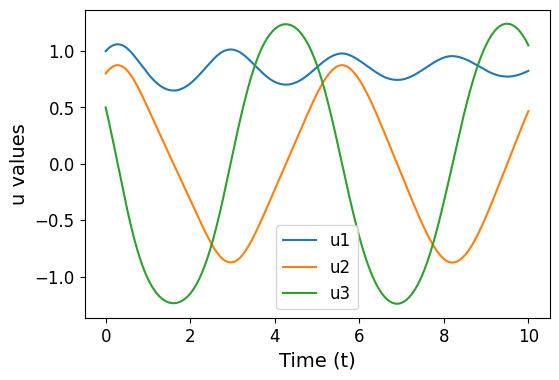

In [4]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [5]:
# Set batch size
data_batch_size = 100
ODE_batch_size = 1000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(1000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 10000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 10, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = simulate_ODEs(u_init, t_span, 5000)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [6]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable

    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [7]:
def u_net(input_layer):
    """Definition of the network for u prediction."""

    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(3)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""

    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.

    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")

    # u-NN
    u = u_net(t_input)

    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])

    if verbose:
        model.summary()

    return model

#### ODE loss

In [8]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    model: PINN model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b

    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)

    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

    # Compute residuals
    res1 = du1_dt - f[:, :1]
    res2 = du2_dt - f[:, 1:]
    res3 = du3_dt - (a*u[:, :1]*u[:, 1:2] + b)
    ODE_residual = tf.concat([res1, res2, res3], axis=1)

    return ODE_residual

#### Gradient descent step

In [9]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)

        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[1.0, 0.8, 0.5]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [10]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [11]:
class PrintParameters(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [13]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = -1, 1

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=2e-2)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight,
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 10.0, 1000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[1.0, 0.8, 0.5]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten())}")


        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(10000).batch(data_batch_size)

        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

Epoch 1:
IC=2.3988e-01,               ODE=1.4376e+00,               data=1.3589e+00,               total_loss=3.0364e+00
1/1 [==============================] - 0s 84ms/step
val_IC: 3.3080e-02, val_ODE: 4.5258e-01, lr: 2.00e-02

a: [-0.88427997], b: [0.9014623]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.6436102447742836
Epoch 2:
IC=5.2119e-02,               ODE=4.0730e-01,               data=4.8718e-01,               total_loss=9.4660e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 8.6464e-02, val_ODE: 1.2653e-01, lr: 2.00e-02

a: [-0.8448961], b: [0.78804004]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.431155964698758
Epoch 3:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4634e-02,               ODE=9.3420e-02,               data=4.8260e-01,               total_loss=6.1066e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0533e-02, val_ODE: 1.2159e-01, lr: 2.00e-02

a: [-0.8330027], b: [0.6857342]
1/1 [==============================] - 0s 14ms/step
RMSE: 0.40049893764712524
Epoch 4:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8189e-02,               ODE=9.9726e-02,               data=3.7875e-01,               total_loss=5.0666e-01
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0299e-02, val_ODE: 5.6626e-02, lr: 2.00e-02

a: [-0.8344575], b: [0.5881735]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.3912139421002585
Epoch 5:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8928e-03,               ODE=6.5954e-02,               data=3.7404e-01,               total_loss=4.4888e-01
1/1 [==============================] - 0s 17ms/step
val_IC: 4.3281e-03, val_ODE: 5.9347e-02, lr: 2.00e-02

a: [-0.84061056], b: [0.4966814]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.37061113866996814
Epoch 6:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5385e-03,               ODE=5.1707e-02,               data=3.6216e-01,               total_loss=4.2041e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0326e-03, val_ODE: 4.2628e-02, lr: 2.00e-02

a: [-0.8478997], b: [0.40810776]
1/1 [==============================] - 0s 14ms/step
RMSE: 0.36788324722775895
Epoch 7:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9416e-03,               ODE=3.8552e-02,               data=3.5847e-01,               total_loss=3.9996e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9283e-03, val_ODE: 2.9517e-02, lr: 2.00e-02

a: [-0.8546714], b: [0.32749054]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.3506456600335593
Epoch 8:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4594e-03,               ODE=2.8130e-02,               data=3.4257e-01,               total_loss=3.7316e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.9732e-04, val_ODE: 2.5972e-02, lr: 2.00e-02

a: [-0.8607742], b: [0.2572665]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.3436370904982808
Epoch 9:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6481e-03,               ODE=2.1688e-02,               data=3.4028e-01,               total_loss=3.6362e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 2.1744e-03, val_ODE: 2.0426e-02, lr: 2.00e-02

a: [-0.86588365], b: [0.195124]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.3326037957889883
Epoch 10:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4563e-03,               ODE=1.8436e-02,               data=3.3552e-01,               total_loss=3.5541e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 2.3669e-03, val_ODE: 1.6041e-02, lr: 2.00e-02

a: [-0.87044936], b: [0.1421677]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.3286477425756777
Epoch 11:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6376e-03,               ODE=1.4781e-02,               data=3.3182e-01,               total_loss=3.4824e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0397e-03, val_ODE: 1.8438e-02, lr: 2.00e-02

a: [-0.874738], b: [0.09900688]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.32576061975891013
Epoch 12:
IC=1.3290e-03,               ODE=1.4945e-02,               data=3.2858e-01,               total_loss=3.4485e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.9044e-04, val_ODE: 2.0283e-02, lr: 2.00e-02

a: [-0.8790625], b: [0.06434767]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.330045768275418
Epoch 13:
IC=8.4112e-04,               ODE=1.4493e-02,               data=3.3081e-01,               total_loss=3.4615e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1449e-03, val_ODE: 1.5003e-02, lr: 2.00e-02

a: [-0.8832924], b: [0.03699877]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.32490426552

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2553e-04,               ODE=1.3027e-02,               data=3.2502e-01,               total_loss=3.3897e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1662e-04, val_ODE: 1.7093e-02, lr: 2.00e-02

a: [-0.8876372], b: [0.0170382]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.322468095408978
Epoch 15:
IC=1.2191e-03,               ODE=1.2114e-02,               data=3.1849e-01,               total_loss=3.3182e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.3254e-05, val_ODE: 1.0842e-02, lr: 2.00e-02

a: [-0.89198375], b: [-0.00180021]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.31663834185336165
Epoch 16:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1787e-03,               ODE=1.2002e-02,               data=3.1629e-01,               total_loss=3.2947e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.5835e-05, val_ODE: 1.0457e-02, lr: 2.00e-02

a: [-0.8967263], b: [-0.01213678]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.3130357589787063
Epoch 17:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0778e-04,               ODE=1.1730e-02,               data=3.1593e-01,               total_loss=3.2837e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.8838e-04, val_ODE: 8.3699e-03, lr: 2.00e-02

a: [-0.90172005], b: [-0.02208182]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.3142130778153385
Epoch 18:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6269e-04,               ODE=1.1392e-02,               data=3.1033e-01,               total_loss=3.2249e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4784e-03, val_ODE: 1.4772e-02, lr: 2.00e-02

a: [-0.90719235], b: [-0.02575284]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.3108377661476649
Epoch 19:
IC=7.1081e-04,               ODE=1.5043e-02,               data=3.1318e-01,               total_loss=3.2894e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.8405e-04, val_ODE: 1.6685e-02, lr: 2.00e-02

a: [-0.91279536], b: [-0.02811797]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.3088390122293958
Epoch 20:
IC=6.2250e-04,               ODE=1.7665e-02,               data=3.1038e-01,               total_loss=3.2867e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 2.6177e-03, val_ODE: 9.7006e-03, lr: 2.00e-02

a: [-0.9188646], b: [-0.03197219]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.30421

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0751e-04,               ODE=1.0554e-02,               data=2.8627e-01,               total_loss=2.9773e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5251e-03, val_ODE: 1.0373e-02, lr: 2.00e-02

a: [-0.9526392], b: [-0.02944025]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.2794740223303112
Epoch 26:
IC=9.2305e-04,               ODE=1.5158e-02,               data=2.8181e-01,               total_loss=2.9789e-01
1/1 [==============================] - 0s 15ms/step
val_IC: 5.2227e-04, val_ODE: 2.1898e-02, lr: 2.00e-02

a: [-0.9598388], b: [-0.03049623]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.2771207164900368
Epoch 27:
IC=1.2195e-03,               ODE=2.0310e-02,               data=2.7240e-01,               total_loss=2.9393e-01
1/1 [==============================] - 0s 15ms/step
val_IC: 2.8509e-03, val_ODE: 2.1417e-02, lr: 2.00e-02

a: [-0.9677371], b: [-0.02991784]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.2623174

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1484e-03,               ODE=8.7378e-03,               data=3.7381e-02,               total_loss=4.7267e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 5.4381e-04, val_ODE: 1.0583e-02, lr: 2.00e-02

a: [-1.3685346], b: [0.07343067]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.03298117874633691
Epoch 55:
IC=1.5856e-03,               ODE=9.2906e-03,               data=3.4693e-02,               total_loss=4.5570e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0142e-03, val_ODE: 9.6010e-03, lr: 2.00e-02

a: [-1.3864434], b: [0.07413996]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.03156461100089739
Epoch 56:
IC=1.5681e-03,               ODE=8.1204e-03,               data=3.0551e-02,               total_loss=4.0239e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.5685e-04, val_ODE: 8.8255e-03, lr: 2.00e-02

a: [-1.4040825], b: [0.07467566]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.02918554

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1518e-04,               ODE=7.1019e-03,               data=2.7367e-02,               total_loss=3.4984e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 2.1742e-05, val_ODE: 6.4478e-03, lr: 2.00e-02

a: [-1.4382776], b: [0.07467361]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.025764030663312988
Epoch 59:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.2260e-04,               ODE=6.0662e-03,               data=2.5206e-02,               total_loss=3.2095e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 4.4882e-04, val_ODE: 5.6386e-03, lr: 2.00e-02

a: [-1.4546583], b: [0.07437914]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.023541859338820633
Epoch 60:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5005e-04,               ODE=6.2586e-03,               data=2.4054e-02,               total_loss=3.0663e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 9.1110e-05, val_ODE: 5.6784e-03, lr: 2.00e-02

a: [-1.4705186], b: [0.07364866]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.028276434189221933
Epoch 61:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1245e-03,               ODE=9.0878e-03,               data=2.8178e-02,               total_loss=3.9391e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 2.9051e-03, val_ODE: 9.8007e-03, lr: 2.00e-02

a: [-1.485865], b: [0.07191663]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.021227756947249266
Epoch 62:
IC=1.7768e-03,               ODE=7.8539e-03,               data=2.1595e-02,               total_loss=3.1226e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 4.4645e-04, val_ODE: 6.9357e-03, lr: 2.00e-02

a: [-1.5006876], b: [0.07162717]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.02246449023790459
Epoch 63:
IC=4.9415e-04,               ODE=6.0297e-03,               data=2.0377e-02,               total_loss=2.6901e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8226e-04, val_ODE: 6.1193e-03, lr: 2.00e-02

a: [-1.5152583], b: [0.06908658]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.02096903

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6300e-04,               ODE=7.6622e-03,               data=2.0081e-02,               total_loss=2.8507e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 4.7108e-04, val_ODE: 6.9026e-03, lr: 2.00e-02

a: [-1.5563148], b: [0.0658918]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.016949875761231855
Epoch 67:
IC=2.6839e-04,               ODE=5.2613e-03,               data=1.7027e-02,               total_loss=2.2557e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2110e-05, val_ODE: 4.7840e-03, lr: 2.00e-02

a: [-1.5694127], b: [0.06507266]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.016278305804263166
Epoch 68:
IC=3.6056e-04,               ODE=5.4290e-03,               data=1.8004e-02,               total_loss=2.3793e-02
1/1 [==============================] - 0s 112ms/step
val_IC: 7.9070e-05, val_ODE: 5.7337e-03, lr: 2.00e-02

a: [-1.5820277], b: [0.06375606]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.016016

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6478e-04,               ODE=4.4157e-03,               data=1.3730e-02,               total_loss=1.8311e-02
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6217e-04, val_ODE: 4.1511e-03, lr: 2.00e-02

a: [-1.639813], b: [0.05686682]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.013243540341695923
Epoch 74:
IC=3.3313e-04,               ODE=4.4641e-03,               data=1.3670e-02,               total_loss=1.8467e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 5.5000e-04, val_ODE: 4.2950e-03, lr: 2.00e-02

a: [-1.6504772], b: [0.05529933]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.012861117058350961
Epoch 75:
IC=5.9925e-04,               ODE=4.8477e-03,               data=1.3495e-02,               total_loss=1.8942e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3366e-04, val_ODE: 3.8151e-03, lr: 2.00e-02

a: [-1.6609542], b: [0.05640853]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0128851

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6844e-04,               ODE=4.3460e-03,               data=1.3621e-02,               total_loss=1.8336e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 3.6323e-04, val_ODE: 3.3167e-03, lr: 2.00e-02

a: [-1.6709299], b: [0.05544452]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.012240171070064807
Epoch 77:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2496e-04,               ODE=3.7016e-03,               data=1.2934e-02,               total_loss=1.6861e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 5.6732e-04, val_ODE: 3.5289e-03, lr: 2.00e-02

a: [-1.6806189], b: [0.05469209]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.011186843643526064
Epoch 78:
IC=3.2730e-04,               ODE=3.3352e-03,               data=1.1819e-02,               total_loss=1.5482e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5823e-04, val_ODE: 3.2863e-03, lr: 2.00e-02

a: [-1.6902686], b: [0.05418679]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.011357709353416276
Epoch 79:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9658e-04,               ODE=4.0609e-03,               data=1.2375e-02,               total_loss=1.6632e-02
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7050e-06, val_ODE: 3.4789e-03, lr: 2.00e-02

a: [-1.6996728], b: [0.05239892]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0104834472385342
Epoch 80:
IC=1.6275e-04,               ODE=3.9297e-03,               data=1.2002e-02,               total_loss=1.6094e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.2066e-05, val_ODE: 3.1624e-03, lr: 2.00e-02

a: [-1.7086943], b: [0.05205088]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.010632285257375484
Epoch 81:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0212e-04,               ODE=4.0890e-03,               data=1.2242e-02,               total_loss=1.6533e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1162e-04, val_ODE: 6.2680e-03, lr: 2.00e-02

a: [-1.7175846], b: [0.05223672]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.012180421216507243
Epoch 82:
IC=3.2167e-04,               ODE=4.2503e-03,               data=1.2101e-02,               total_loss=1.6673e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 3.1429e-04, val_ODE: 5.5715e-03, lr: 2.00e-02

a: [-1.7262646], b: [0.05210843]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.011258368748461903
Epoch 83:
IC=2.0970e-04,               ODE=3.9717e-03,               data=1.0757e-02,               total_loss=1.4939e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5696e-05, val_ODE: 3.9145e-03, lr: 2.00e-02

a: [-1.7346674], b: [0.05225093]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.010063

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7740e-05,               ODE=2.7517e-03,               data=1.0253e-02,               total_loss=1.3082e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 2.2965e-04, val_ODE: 3.8908e-03, lr: 2.00e-02

a: [-1.7512323], b: [0.05114349]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.009189663742659686
Epoch 86:
IC=1.4829e-04,               ODE=3.4471e-03,               data=9.8551e-03,               total_loss=1.3450e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0448e-04, val_ODE: 2.2588e-03, lr: 2.00e-02

a: [-1.7591842], b: [0.05104603]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.009799504915723673
Epoch 87:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0260e-04,               ODE=3.3044e-03,               data=9.9618e-03,               total_loss=1.3369e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7863e-04, val_ODE: 2.0323e-03, lr: 2.00e-02

a: [-1.7664865], b: [0.05062341]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.012629465742555147
Epoch 88:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3169e-04,               ODE=3.6637e-03,               data=1.0237e-02,               total_loss=1.4132e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 3.2895e-04, val_ODE: 3.9922e-03, lr: 2.00e-02

a: [-1.7737232], b: [0.05036583]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.009461667289338052
Epoch 89:
IC=2.4134e-04,               ODE=3.0594e-03,               data=9.3443e-03,               total_loss=1.2645e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8749e-04, val_ODE: 2.5227e-03, lr: 2.00e-02

a: [-1.780628], b: [0.04936398]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.008529332458048945
Epoch 90:
IC=8.3244e-05,               ODE=2.9951e-03,               data=8.9861e-03,               total_loss=1.2064e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.8955e-05, val_ODE: 3.6535e-03, lr: 2.00e-02

a: [-1.7877427], b: [0.05026835]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0109686

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3879e-04,               ODE=4.4496e-03,               data=9.4649e-03,               total_loss=1.4053e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 5.7591e-05, val_ODE: 5.0374e-03, lr: 2.00e-02

a: [-1.8130875], b: [0.05122203]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.009547893500032135
Epoch 95:
IC=1.5667e-04,               ODE=4.2464e-03,               data=9.5472e-03,               total_loss=1.3950e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0488e-04, val_ODE: 5.3647e-03, lr: 2.00e-02

a: [-1.8186204], b: [0.05224581]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.008114426737433659
Epoch 96:
IC=2.0342e-04,               ODE=3.6265e-03,               data=8.4879e-03,               total_loss=1.2318e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 9.2796e-05, val_ODE: 2.3653e-03, lr: 2.00e-02

a: [-1.8243116], b: [0.05204594]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.007587

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7914e-05,               ODE=2.0389e-03,               data=7.3696e-03,               total_loss=9.4464e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 5.8270e-05, val_ODE: 1.9030e-03, lr: 2.00e-02

a: [-1.8525689], b: [0.05170889]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.007719597302710457
Epoch 102:
IC=2.4117e-04,               ODE=2.2305e-03,               data=7.4380e-03,               total_loss=9.9097e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 7.8572e-04, val_ODE: 2.6718e-03, lr: 2.00e-02

a: [-1.8581072], b: [0.05148637]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.007184095118768121
Epoch 103:
IC=2.3662e-04,               ODE=1.9424e-03,               data=7.1897e-03,               total_loss=9.3687e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8088e-04, val_ODE: 2.1233e-03, lr: 2.00e-02

a: [-1.8635179], b: [0.05070808]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0071

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7243e-05,               ODE=2.7736e-03,               data=7.5254e-03,               total_loss=1.0376e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3878e-04, val_ODE: 2.7966e-03, lr: 2.00e-02

a: [-1.8735305], b: [0.04955596]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.006796438709829981
Epoch 106:
IC=1.4068e-04,               ODE=3.1495e-03,               data=7.3706e-03,               total_loss=1.0661e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 2.7431e-04, val_ODE: 2.9132e-03, lr: 2.00e-02

a: [-1.8782316], b: [0.04974484]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0074554724289151155
Epoch 107:
IC=1.5419e-04,               ODE=4.1881e-03,               data=7.4525e-03,               total_loss=1.1795e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0973e-04, val_ODE: 4.3112e-03, lr: 2.00e-02

a: [-1.8824513], b: [0.050256]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00831

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9560e-04,               ODE=2.7272e-03,               data=6.5043e-03,               total_loss=9.4271e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1533e-05, val_ODE: 1.5601e-03, lr: 2.00e-02

a: [-1.8949764], b: [0.05099824]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0063801074817518184
Epoch 111:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.3269e-05,               ODE=1.9357e-03,               data=6.5525e-03,               total_loss=8.5714e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6354e-04, val_ODE: 2.3432e-03, lr: 2.00e-02

a: [-1.8992971], b: [0.05025863]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0064537817244947554
Epoch 112:
IC=1.1297e-04,               ODE=2.1762e-03,               data=6.4915e-03,               total_loss=8.7807e-03
1/1 [==============================] - 0s 19ms/step
val_IC: 5.1242e-05, val_ODE: 1.3948e-03, lr: 2.00e-02

a: [-1.9035906], b: [0.04965979]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.006085625104216861
Epoch 113:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7299e-04,               ODE=2.9872e-03,               data=6.6199e-03,               total_loss=9.7801e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1342e-04, val_ODE: 3.0958e-03, lr: 2.00e-02

a: [-1.9078313], b: [0.05063831]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.006933738615729668
Epoch 114:
IC=1.6885e-04,               ODE=3.3078e-03,               data=7.3273e-03,               total_loss=1.0804e-02
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6129e-04, val_ODE: 4.7052e-03, lr: 2.00e-02

a: [-1.9115522], b: [0.05099067]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.008218639123999696
Epoch 115:
IC=5.3916e-04,               ODE=3.1761e-03,               data=6.3858e-03,               total_loss=1.0101e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3498e-03, val_ODE: 2.0486e-03, lr: 2.00e-02

a: [-1.9152498], b: [0.05095469]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0060

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2087e-05,               ODE=2.3203e-03,               data=5.9753e-03,               total_loss=8.3377e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5144e-04, val_ODE: 3.2998e-03, lr: 2.00e-02

a: [-1.9299437], b: [0.04955205]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.007567145369540226
Epoch 120:
IC=1.9205e-04,               ODE=2.8653e-03,               data=6.5259e-03,               total_loss=9.5832e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 8.6581e-05, val_ODE: 1.9848e-03, lr: 2.00e-02

a: [-1.9334339], b: [0.04962179]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.005853995425715845
Epoch 121:
IC=2.7069e-04,               ODE=2.3897e-03,               data=5.8738e-03,               total_loss=8.5342e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7923e-04, val_ODE: 2.6383e-03, lr: 2.00e-02

a: [-1.9368864], b: [0.04951843]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0060

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0335e-05,               ODE=1.6138e-03,               data=5.3953e-03,               total_loss=7.0794e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6859e-04, val_ODE: 2.4402e-03, lr: 2.00e-02

a: [-1.9562844], b: [0.04831327]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.005105090182894619
Epoch 129:
IC=1.6091e-04,               ODE=2.0721e-03,               data=5.1483e-03,               total_loss=7.3813e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8639e-04, val_ODE: 7.4473e-03, lr: 2.00e-02

a: [-1.9593669], b: [0.04829688]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0063575295036301825
Epoch 130:
IC=2.0087e-04,               ODE=4.3075e-03,               data=6.1787e-03,               total_loss=1.0687e-02
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2273e-05, val_ODE: 2.7348e-03, lr: 2.00e-02

a: [-1.9614116], b: [0.04887052]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.005

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7107e-05,               ODE=1.1677e-03,               data=3.4784e-03,               total_loss=4.6832e-03
1/1 [==============================] - 0s 19ms/step
val_IC: 1.4984e-04, val_ODE: 1.7117e-03, lr: 2.00e-02

a: [-1.9942956], b: [0.04396102]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0034955056701128366
Epoch 159:
IC=9.0570e-05,               ODE=1.9285e-03,               data=3.5498e-03,               total_loss=5.5688e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3129e-04, val_ODE: 3.9085e-03, lr: 2.00e-02

a: [-1.9962432], b: [0.04284781]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0037489551158234485
Epoch 160:
IC=9.0805e-05,               ODE=2.3582e-03,               data=3.6021e-03,               total_loss=6.0511e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.6877e-05, val_ODE: 1.6877e-03, lr: 2.00e-02

a: [-1.9977922], b: [0.04145187]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0581e-05,               ODE=1.0126e-03,               data=1.5735e-03,               total_loss=2.6567e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9885e-05, val_ODE: 8.6248e-04, lr: 2.00e-02

a: [-2.0055258], b: [0.0217684]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0014101589759431268
Epoch 193:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7195e-05,               ODE=2.2111e-03,               data=1.9090e-03,               total_loss=4.1673e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3673e-05, val_ODE: 2.9663e-03, lr: 2.00e-02

a: [-2.0062509], b: [0.02119478]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.002073987812041131
Epoch 194:
IC=8.7054e-05,               ODE=2.9178e-03,               data=2.0594e-03,               total_loss=5.0643e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 3.2773e-04, val_ODE: 4.9647e-03, lr: 2.00e-02

a: [-2.0061004], b: [0.02148572]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0027853140261256746
Epoch 195:
IC=2.2275e-04,               ODE=5.7344e-03,               data=2.8997e-03,               total_loss=8.8569e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4576e-04, val_ODE: 6.2673e-03, lr: 2.00e-02

a: [-2.0050707], b: [0.02391618]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.004

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1581e-04,               ODE=4.0612e-03,               data=3.2166e-03,               total_loss=7.3935e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 8.0730e-05, val_ODE: 1.2634e-03, lr: 2.00e-02

a: [-2.0015585], b: [0.02378998]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.002266511521496997
Epoch 198:
IC=1.7116e-04,               ODE=3.5580e-03,               data=2.4745e-03,               total_loss=6.2037e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.3336e-04, val_ODE: 1.7371e-03, lr: 2.00e-02

a: [-2.000498], b: [0.0228405]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0015656884130533226
Epoch 199:
IC=2.1372e-04,               ODE=2.1865e-03,               data=2.0547e-03,               total_loss=4.4549e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.3409e-04, val_ODE: 1.5362e-03, lr: 2.00e-02

a: [-2.0002398], b: [0.02268173]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00151

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7807e-05,               ODE=8.0534e-04,               data=1.0426e-03,               total_loss=1.8658e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 7.5653e-06, val_ODE: 6.2021e-04, lr: 2.00e-02

a: [-1.9499539], b: [0.01145764]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0012834637235950483
Epoch 240:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.4394e-06,               ODE=7.3240e-04,               data=9.8516e-04,               total_loss=1.7260e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4011e-05, val_ODE: 6.8283e-04, lr: 2.00e-02

a: [-1.9544469], b: [0.01150096]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0008988109594385018
Epoch 241:
IC=1.7025e-05,               ODE=7.6913e-04,               data=1.0072e-03,               total_loss=1.7934e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 3.7181e-05, val_ODE: 6.9857e-04, lr: 2.00e-02

a: [-1.958865], b: [0.01115771]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.001255630133708279
Epoch 242:
IC=4.0444e-05,               ODE=8.4472e-04,               data=9.9234e-04,               total_loss=1.8775e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 1.2772e-05, val_ODE: 9.3887e-04, lr: 2.00e-02

a: [-1.9626781], b: [0.01119323]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0008

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0491e-05,               ODE=6.7391e-04,               data=7.7674e-04,               total_loss=1.4711e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3684e-05, val_ODE: 6.3211e-04, lr: 2.00e-02

a: [-1.9861894], b: [0.0098416]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0007044126173315545
Epoch 251:
IC=1.7873e-05,               ODE=6.4439e-04,               data=7.5746e-04,               total_loss=1.4197e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8748e-05, val_ODE: 9.8871e-04, lr: 2.00e-02

a: [-1.988351], b: [0.00938433]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0008702731578760037
Epoch 252:
IC=5.3014e-05,               ODE=7.8795e-04,               data=7.7804e-04,               total_loss=1.6190e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6922e-06, val_ODE: 8.0425e-04, lr: 2.00e-02

a: [-1.990185], b: [0.00933158]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00069

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5688e-05,               ODE=6.4981e-04,               data=1.0396e-03,               total_loss=1.7051e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 6.4599e-06, val_ODE: 8.0551e-04, lr: 2.00e-02

a: [-1.9774266], b: [0.01003486]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0011495434983155434
Epoch 288:
IC=6.4849e-05,               ODE=9.4308e-04,               data=1.0608e-03,               total_loss=2.0687e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2901e-05, val_ODE: 8.0798e-04, lr: 2.00e-02

a: [-1.9802364], b: [0.00987902]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000744352310416478
Epoch 289:
IC=2.3823e-05,               ODE=7.8536e-04,               data=7.6596e-04,               total_loss=1.5751e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 3.5967e-05, val_ODE: 8.2921e-04, lr: 2.00e-02

a: [-1.9828318], b: [0.00964265]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0384e-06,               ODE=7.0337e-04,               data=7.4245e-04,               total_loss=1.4549e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 9.8714e-06, val_ODE: 6.6740e-04, lr: 2.00e-02

a: [-1.9946625], b: [0.00942341]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0006207958116820674
Epoch 296:
IC=1.6646e-05,               ODE=6.0409e-04,               data=5.9974e-04,               total_loss=1.2205e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.6965e-05, val_ODE: 5.1079e-04, lr: 2.00e-02

a: [-1.9960283], b: [0.00891693]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0005387081292739318
Epoch 297:
IC=1.1088e-05,               ODE=5.7066e-04,               data=6.0378e-04,               total_loss=1.1855e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3560e-06, val_ODE: 6.4113e-04, lr: 2.00e-02

a: [-1.9973501], b: [0.00918238]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4774e-06,               ODE=5.3785e-04,               data=6.1837e-04,               total_loss=1.1627e-03
1/1 [==============================] - 0s 51ms/step
val_IC: 1.1999e-05, val_ODE: 5.5316e-04, lr: 2.00e-02

a: [-1.9999045], b: [0.00856154]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0005481339069531622
Epoch 300:
IC=1.6674e-05,               ODE=5.7229e-04,               data=5.7554e-04,               total_loss=1.1645e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0711e-05, val_ODE: 7.3695e-04, lr: 2.00e-02

a: [-2.0011046], b: [0.00882696]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00076244459944681
Epoch 301:
IC=1.0818e-05,               ODE=7.0945e-04,               data=6.8621e-04,               total_loss=1.4065e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0024e-05, val_ODE: 6.1661e-04, lr: 2.00e-02

a: [-2.0021255], b: [0.00914726]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0005

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1680e-06,               ODE=4.7041e-04,               data=5.6029e-04,               total_loss=1.0349e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0163e-06, val_ODE: 4.7436e-04, lr: 2.00e-02

a: [-2.006311], b: [0.00826006]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0004993373454657633
Epoch 308:
IC=1.5756e-05,               ODE=7.0969e-04,               data=6.2489e-04,               total_loss=1.3503e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 7.7777e-07, val_ODE: 5.4244e-04, lr: 2.00e-02

a: [-2.0068293], b: [0.00848086]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0005066738625248262
Epoch 309:
IC=1.2028e-05,               ODE=5.5500e-04,               data=5.5753e-04,               total_loss=1.1246e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 6.9536e-06, val_ODE: 4.5428e-04, lr: 2.00e-02

a: [-2.007246], b: [0.00794581]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0004

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8613e-07,               ODE=4.2067e-04,               data=5.9817e-04,               total_loss=1.0196e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 7.3075e-07, val_ODE: 4.3586e-04, lr: 5.00e-03

a: [-2.0455627], b: [0.0068343]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0005783408242276486
Epoch 529:
IC=1.9342e-06,               ODE=4.3147e-04,               data=6.1351e-04,               total_loss=1.0469e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 8.6472e-07, val_ODE: 4.7372e-04, lr: 5.00e-03

a: [-2.0452125], b: [0.00681486]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0006032167416754606
Epoch 530:
IC=7.2067e-07,               ODE=4.3542e-04,               data=6.0777e-04,               total_loss=1.0439e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0536e-06, val_ODE: 4.3422e-04, lr: 5.00e-03

a: [-2.0449674], b: [0.0067409]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0005

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9419e-07,               ODE=4.4036e-04,               data=5.7203e-04,               total_loss=1.0132e-03
1/1 [==============================] - 0s 38ms/step
val_IC: 4.0754e-07, val_ODE: 4.0040e-04, lr: 5.00e-03

a: [-2.0433097], b: [0.00670379]
1/1 [==============================] - 0s 51ms/step
RMSE: 0.0005502904995780759
Epoch 536:
IC=1.0826e-06,               ODE=4.1590e-04,               data=5.6017e-04,               total_loss=9.7715e-04
1/1 [==============================] - 0s 47ms/step
val_IC: 1.8001e-06, val_ODE: 4.2259e-04, lr: 5.00e-03

a: [-2.042888], b: [0.00658218]
1/1 [==============================] - 0s 42ms/step
RMSE: 0.0005536393047547565
Epoch 537:
IC=1.1170e-06,               ODE=4.0820e-04,               data=5.7341e-04,               total_loss=9.8272e-04
1/1 [==============================] - 0s 66ms/step
val_IC: 5.9261e-07, val_ODE: 4.0728e-04, lr: 5.00e-03

a: [-2.0426955], b: [0.00668923]
1/1 [==============================] - 0s 87ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7861e-06,               ODE=3.9280e-04,               data=5.5481e-04,               total_loss=9.5040e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4063e-06, val_ODE: 4.1221e-04, lr: 5.00e-03

a: [-2.0412097], b: [0.00635801]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0005410418927764255
Epoch 543:
IC=7.3615e-07,               ODE=4.0411e-04,               data=5.3836e-04,               total_loss=9.4321e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 4.0415e-07, val_ODE: 4.1600e-04, lr: 5.00e-03

a: [-2.040841], b: [0.00621267]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0005239711953369213
Epoch 544:
IC=7.6709e-07,               ODE=4.0766e-04,               data=5.3665e-04,               total_loss=9.4507e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6524e-06, val_ODE: 4.1657e-04, lr: 5.00e-03

a: [-2.04054], b: [0.00629799]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00051

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1401e-06,               ODE=3.6819e-04,               data=5.0576e-04,               total_loss=8.7508e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 7.0587e-07, val_ODE: 3.8820e-04, lr: 5.00e-03

a: [-2.0381732], b: [0.00601756]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0004940142523307509
Epoch 553:
IC=1.2639e-06,               ODE=3.8847e-04,               data=5.0039e-04,               total_loss=8.9013e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.7445e-06, val_ODE: 3.6366e-04, lr: 5.00e-03

a: [-2.0378997], b: [0.00596516]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0004927766375402058
Epoch 554:
IC=2.5746e-06,               ODE=3.6656e-04,               data=4.9335e-04,               total_loss=8.6248e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.5432e-06, val_ODE: 3.5593e-04, lr: 5.00e-03

a: [-2.037578], b: [0.00590798]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.0302e-07,               ODE=3.6340e-04,               data=4.8692e-04,               total_loss=8.5112e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 6.5373e-07, val_ODE: 3.5654e-04, lr: 5.00e-03

a: [-2.0373008], b: [0.00598796]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00048036942781670407
Epoch 556:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9121e-07,               ODE=3.5900e-04,               data=4.9273e-04,               total_loss=8.5223e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3087e-07, val_ODE: 3.6796e-04, lr: 5.00e-03

a: [-2.0370731], b: [0.0059179]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00046937211309384637
Epoch 557:
IC=1.1211e-06,               ODE=3.5798e-04,               data=4.9094e-04,               total_loss=8.5004e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 6.3545e-07, val_ODE: 3.4151e-04, lr: 5.00e-03

a: [-2.0368953], b: [0.00590183]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0004721020647616895
Epoch 558:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0787e-06,               ODE=3.4966e-04,               data=4.8348e-04,               total_loss=8.3421e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3529e-06, val_ODE: 3.8659e-04, lr: 5.00e-03

a: [-2.0366664], b: [0.00582501]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00047348090139750376
Epoch 559:
IC=6.8475e-07,               ODE=3.6598e-04,               data=4.8862e-04,               total_loss=8.5528e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0498e-06, val_ODE: 3.9617e-04, lr: 5.00e-03

a: [-2.0363894], b: [0.00579666]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0004982230469618432
Epoch 560:
IC=8.3964e-07,               ODE=3.5793e-04,               data=4.9385e-04,               total_loss=8.5263e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.9918e-07, val_ODE: 3.6491e-04, lr: 5.00e-03

a: [-2.0361712], b: [0.00578728]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1841e-07,               ODE=3.5131e-04,               data=4.6139e-04,               total_loss=8.1342e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0015e-06, val_ODE: 3.4463e-04, lr: 5.00e-03

a: [-2.0341654], b: [0.00544382]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0004576925116902012
Epoch 568:
IC=5.6736e-07,               ODE=3.3224e-04,               data=4.4422e-04,               total_loss=7.7702e-04
1/1 [==============================] - 0s 69ms/step
val_IC: 5.2948e-07, val_ODE: 3.4112e-04, lr: 5.00e-03

a: [-2.033928], b: [0.00544712]
1/1 [==============================] - 0s 108ms/step
RMSE: 0.0004337050918388115
Epoch 569:
IC=4.8419e-07,               ODE=3.5865e-04,               data=4.4594e-04,               total_loss=8.0507e-04
1/1 [==============================] - 0s 41ms/step
val_IC: 1.1122e-06, val_ODE: 4.2296e-04, lr: 5.00e-03

a: [-2.0336237], b: [0.00551516]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5443e-07,               ODE=3.2526e-04,               data=4.3309e-04,               total_loss=7.5891e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8612e-07, val_ODE: 3.3337e-04, lr: 5.00e-03

a: [-2.0328622], b: [0.00533741]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00043509448174727707
Epoch 573:
IC=4.9423e-07,               ODE=3.1713e-04,               data=4.3606e-04,               total_loss=7.5368e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 7.2234e-07, val_ODE: 3.1944e-04, lr: 5.00e-03

a: [-2.0325823], b: [0.00536146]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.000418618860875553
Epoch 574:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9868e-07,               ODE=3.1451e-04,               data=4.3636e-04,               total_loss=7.5157e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0600e-07, val_ODE: 3.1691e-04, lr: 5.00e-03

a: [-2.0323668], b: [0.00534853]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00042760875085699204
Epoch 575:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0255e-07,               ODE=3.2048e-04,               data=4.3250e-04,               total_loss=7.5328e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.4984e-07, val_ODE: 3.1507e-04, lr: 5.00e-03

a: [-2.0321894], b: [0.00534622]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00041787724593111053
Epoch 576:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7247e-07,               ODE=3.1741e-04,               data=4.2682e-04,               total_loss=7.4480e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 9.1861e-07, val_ODE: 3.3282e-04, lr: 5.00e-03

a: [-2.0319555], b: [0.00530347]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0004160067225394812
Epoch 577:
IC=8.0586e-07,               ODE=3.3043e-04,               data=4.3633e-04,               total_loss=7.6756e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4543e-06, val_ODE: 3.2594e-04, lr: 5.00e-03

a: [-2.0316713], b: [0.00531149]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0004163385446941241
Epoch 578:
IC=8.3145e-07,               ODE=3.3277e-04,               data=4.3020e-04,               total_loss=7.6381e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2197e-07, val_ODE: 3.3385e-04, lr: 5.00e-03

a: [-2.0313926], b: [0.00523557]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9019e-07,               ODE=3.0437e-04,               data=4.1117e-04,               total_loss=7.1603e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8326e-06, val_ODE: 2.9754e-04, lr: 5.00e-03

a: [-2.0300097], b: [0.00510406]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003969780885586672
Epoch 585:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6866e-06,               ODE=3.0648e-04,               data=4.0536e-04,               total_loss=7.1452e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.2605e-06, val_ODE: 3.0796e-04, lr: 5.00e-03

a: [-2.0298476], b: [0.00507709]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0003986627882602788
Epoch 586:
IC=2.4441e-06,               ODE=3.2843e-04,               data=4.1294e-04,               total_loss=7.4381e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6221e-07, val_ODE: 3.4964e-04, lr: 5.00e-03

a: [-2.0295355], b: [0.00503746]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00039997782806951734
Epoch 587:
IC=5.5851e-07,               ODE=3.1330e-04,               data=3.9822e-04,               total_loss=7.1208e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0591e-07, val_ODE: 2.9710e-04, lr: 5.00e-03

a: [-2.029325], b: [0.00511391]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5487e-07,               ODE=3.1151e-04,               data=4.0321e-04,               total_loss=7.1527e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 4.2778e-07, val_ODE: 3.1943e-04, lr: 5.00e-03

a: [-2.02903], b: [0.00503663]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00039513791088555567
Epoch 589:
IC=7.3505e-07,               ODE=3.0489e-04,               data=3.9784e-04,               total_loss=7.0347e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 7.9149e-07, val_ODE: 3.0517e-04, lr: 5.00e-03

a: [-2.0289094], b: [0.00500067]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0003871152564329539
Epoch 590:
IC=9.7812e-07,               ODE=2.9924e-04,               data=3.9745e-04,               total_loss=6.9767e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9034e-07, val_ODE: 3.4345e-04, lr: 5.00e-03

a: [-2.0286365], b: [0.00509263]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0484e-06,               ODE=2.8892e-04,               data=3.9108e-04,               total_loss=6.8105e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 8.5305e-07, val_ODE: 3.0266e-04, lr: 5.00e-03

a: [-2.0278206], b: [0.00487517]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00037986534535023583
Epoch 595:
IC=8.2578e-07,               ODE=2.9105e-04,               data=3.8440e-04,               total_loss=6.7628e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 9.4200e-07, val_ODE: 3.4579e-04, lr: 5.00e-03

a: [-2.0276208], b: [0.0049106]
1/1 [==============================] - 0s 14ms/step
RMSE: 0.0003908685153703653
Epoch 596:
IC=6.2084e-07,               ODE=3.0300e-04,               data=3.8677e-04,               total_loss=6.9039e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6274e-06, val_ODE: 2.9369e-04, lr: 5.00e-03

a: [-2.0274043], b: [0.00499057]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1200e-06,               ODE=2.8987e-04,               data=3.7616e-04,               total_loss=6.6715e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9641e-06, val_ODE: 2.9084e-04, lr: 5.00e-03

a: [-2.0267544], b: [0.00481743]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00037025462484291746
Epoch 600:
IC=9.4712e-07,               ODE=2.7394e-04,               data=3.9312e-04,               total_loss=6.6800e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.6054e-06, val_ODE: 2.8309e-04, lr: 5.00e-03

a: [-2.0265734], b: [0.00478774]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00036931471753613254
Epoch 601:
IC=1.2280e-06,               ODE=2.9529e-04,               data=3.7860e-04,               total_loss=6.7512e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 6.3948e-07, val_ODE: 2.8774e-04, lr: 5.00e-03

a: [-2.0263433], b: [0.00470985]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8154e-06,               ODE=2.6588e-04,               data=3.6114e-04,               total_loss=6.2883e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 7.7719e-07, val_ODE: 2.8457e-04, lr: 5.00e-03

a: [-2.0252357], b: [0.00478125]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00035282792785071846
Epoch 608:
IC=9.8127e-07,               ODE=2.6514e-04,               data=3.6012e-04,               total_loss=6.2624e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.7183e-08, val_ODE: 2.5621e-04, lr: 5.00e-03

a: [-2.0250955], b: [0.00473107]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00036075013938647677
Epoch 609:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3491e-07,               ODE=2.5562e-04,               data=3.5843e-04,               total_loss=6.1439e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 6.4177e-07, val_ODE: 2.8425e-04, lr: 5.00e-03

a: [-2.0249147], b: [0.0046754]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00035279906380951913
Epoch 610:
IC=1.1767e-06,               ODE=2.7396e-04,               data=3.6412e-04,               total_loss=6.3926e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.9918e-07, val_ODE: 2.6279e-04, lr: 5.00e-03

a: [-2.024706], b: [0.00454486]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00037206943121685264
Epoch 611:
IC=1.2742e-06,               ODE=2.6772e-04,               data=3.5976e-04,               total_loss=6.2876e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5865e-07, val_ODE: 2.5867e-04, lr: 5.00e-03

a: [-2.024586], b: [0.00465429]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0472e-07,               ODE=2.5334e-04,               data=3.5037e-04,               total_loss=6.0441e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 7.7982e-08, val_ODE: 2.6244e-04, lr: 5.00e-03

a: [-2.0243497], b: [0.00454364]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003550371816399696
Epoch 614:
IC=5.9381e-07,               ODE=2.5657e-04,               data=3.5796e-04,               total_loss=6.1512e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6105e-07, val_ODE: 2.4626e-04, lr: 5.00e-03

a: [-2.024207], b: [0.00448816]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003450377090858116
Epoch 615:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4146e-07,               ODE=2.4901e-04,               data=3.6105e-04,               total_loss=6.1051e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4932e-06, val_ODE: 2.7908e-04, lr: 5.00e-03

a: [-2.0240333], b: [0.00441865]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00037541830375386074
Epoch 616:
IC=8.8670e-07,               ODE=2.8474e-04,               data=3.7732e-04,               total_loss=6.6295e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 9.5920e-07, val_ODE: 2.5389e-04, lr: 5.00e-03

a: [-2.0238352], b: [0.00434394]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0004600631269055744
Epoch 617:
IC=1.0010e-06,               ODE=2.7521e-04,               data=3.8775e-04,               total_loss=6.6396e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9301e-07, val_ODE: 2.7426e-04, lr: 5.00e-03

a: [-2.023648], b: [0.00432108]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6379e-07,               ODE=2.4891e-04,               data=3.5202e-04,               total_loss=6.0139e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7398e-07, val_ODE: 2.4519e-04, lr: 5.00e-03

a: [-2.0232284], b: [0.00442012]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00034026251871237305
Epoch 620:
IC=8.8610e-07,               ODE=2.6263e-04,               data=3.4727e-04,               total_loss=6.1079e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7392e-07, val_ODE: 2.4507e-04, lr: 5.00e-03

a: [-2.0231311], b: [0.00448027]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00034324007271048995
Epoch 621:
IC=7.1130e-07,               ODE=2.7982e-04,               data=3.6022e-04,               total_loss=6.4075e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 5.8759e-07, val_ODE: 3.6436e-04, lr: 5.00e-03

a: [-2.022914], b: [0.00456419]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6736e-06,               ODE=2.8311e-04,               data=3.5216e-04,               total_loss=6.3694e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 8.7218e-07, val_ODE: 3.1857e-04, lr: 5.00e-03

a: [-2.0223799], b: [0.00441992]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00034417138863301606
Epoch 625:
IC=6.7554e-07,               ODE=2.6273e-04,               data=3.5101e-04,               total_loss=6.1442e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6486e-06, val_ODE: 2.4345e-04, lr: 5.00e-03

a: [-2.0222118], b: [0.00439099]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00035804670624847024
Epoch 626:
IC=1.3963e-06,               ODE=2.7578e-04,               data=3.4596e-04,               total_loss=6.2313e-04
1/1 [==============================] - 0s 19ms/step
val_IC: 3.7934e-06, val_ODE: 3.6760e-04, lr: 5.00e-03

a: [-2.0219605], b: [0.00428475]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2322e-06,               ODE=2.7454e-04,               data=3.5949e-04,               total_loss=6.3527e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4032e-06, val_ODE: 2.3988e-04, lr: 5.00e-03

a: [-2.021666], b: [0.00441663]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003253397640309946
Epoch 629:
IC=8.6503e-07,               ODE=2.4236e-04,               data=3.2788e-04,               total_loss=5.7111e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7911e-06, val_ODE: 2.4767e-04, lr: 5.00e-03

a: [-2.02152], b: [0.00434393]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003392564780387308
Epoch 630:
IC=1.5662e-06,               ODE=2.4254e-04,               data=3.3925e-04,               total_loss=5.8335e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2261e-06, val_ODE: 2.5089e-04, lr: 5.00e-03

a: [-2.0213592], b: [0.00438887]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00033

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8410e-06,               ODE=2.5048e-04,               data=3.2410e-04,               total_loss=5.7642e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0093e-06, val_ODE: 2.2308e-04, lr: 5.00e-03

a: [-2.0211344], b: [0.00428542]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0003169825574435155
Epoch 633:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0015e-06,               ODE=2.3074e-04,               data=3.1786e-04,               total_loss=5.4959e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0769e-07, val_ODE: 2.2574e-04, lr: 5.00e-03

a: [-2.0209622], b: [0.00422279]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0003130403899616055
Epoch 634:
IC=6.1562e-07,               ODE=2.3202e-04,               data=3.2522e-04,               total_loss=5.5786e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0341e-07, val_ODE: 2.4231e-04, lr: 5.00e-03

a: [-2.020772], b: [0.00415392]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0003190543525370244
Epoch 635:
IC=1.6119e-06,               ODE=2.7358e-04,               data=3.2311e-04,               total_loss=5.9830e-04
1/1 [==============================] - 0s 19ms/step
val_IC: 3.4151e-08, val_ODE: 4.1269e-04, lr: 5.00e-03

a: [-2.0205991], b: [0.00396246]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3555e-06,               ODE=2.1508e-04,               data=3.0881e-04,               total_loss=5.2525e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 7.4264e-07, val_ODE: 2.3872e-04, lr: 5.00e-03

a: [-2.0200274], b: [0.00400427]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00031369445421328606
Epoch 639:
IC=7.3077e-07,               ODE=2.3299e-04,               data=3.1098e-04,               total_loss=5.4470e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.6217e-07, val_ODE: 2.0805e-04, lr: 5.00e-03

a: [-2.0198972], b: [0.00404212]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00031001037495389724
Epoch 640:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2521e-06,               ODE=2.3571e-04,               data=3.1930e-04,               total_loss=5.5626e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.4269e-06, val_ODE: 3.4215e-04, lr: 5.00e-03

a: [-2.0198278], b: [0.00406452]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00033508136966338035
Epoch 641:
IC=2.7151e-06,               ODE=2.6883e-04,               data=3.3083e-04,               total_loss=6.0238e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7217e-06, val_ODE: 2.6387e-04, lr: 5.00e-03

a: [-2.019776], b: [0.00400477]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0003123446281854826
Epoch 642:
IC=1.4323e-06,               ODE=2.3804e-04,               data=3.4573e-04,               total_loss=5.8521e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3398e-06, val_ODE: 2.5050e-04, lr: 5.00e-03

a: [-2.0195901], b: [0.00397704]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.4949e-07,               ODE=2.1624e-04,               data=2.9775e-04,               total_loss=5.1484e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 8.8029e-08, val_ODE: 2.3422e-04, lr: 5.00e-03

a: [-2.0168507], b: [0.00375921]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00032772060624644187
Epoch 656:
IC=1.7351e-06,               ODE=2.4184e-04,               data=3.3244e-04,               total_loss=5.7602e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.6114e-06, val_ODE: 2.1740e-04, lr: 5.00e-03

a: [-2.0168307], b: [0.00371023]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00030737022407263735
Epoch 657:
IC=1.4843e-06,               ODE=2.2456e-04,               data=3.1434e-04,               total_loss=5.4039e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.8593e-06, val_ODE: 2.6365e-04, lr: 5.00e-03

a: [-2.0168889], b: [0.00368975]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2597e-07,               ODE=2.6552e-04,               data=3.4561e-04,               total_loss=6.1166e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4065e-06, val_ODE: 2.0228e-04, lr: 5.00e-03

a: [-2.016928], b: [0.00384406]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00040170657449757174
Epoch 663:
IC=1.4808e-06,               ODE=2.2500e-04,               data=3.0867e-04,               total_loss=5.3514e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6993e-06, val_ODE: 3.0940e-04, lr: 5.00e-03

a: [-2.016997], b: [0.003766]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0002984076252445546
Epoch 664:
IC=1.3519e-06,               ODE=3.0688e-04,               data=3.0765e-04,               total_loss=6.1588e-04
1/1 [==============================] - 0s 17ms/step
val_IC: 2.0107e-06, val_ODE: 2.6015e-04, lr: 5.00e-03

a: [-2.0169537], b: [0.00363698]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00031

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8297e-06,               ODE=1.9559e-04,               data=2.7548e-04,               total_loss=4.7291e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8962e-06, val_ODE: 2.0210e-04, lr: 5.00e-03

a: [-2.0155883], b: [0.00322278]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0002903691079997807
Epoch 677:
IC=1.4697e-06,               ODE=1.9024e-04,               data=2.8508e-04,               total_loss=4.7679e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3583e-06, val_ODE: 1.6662e-04, lr: 5.00e-03

a: [-2.015492], b: [0.00300164]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00024995168213349654
Epoch 678:
IC=8.3419e-07,               ODE=1.8423e-04,               data=2.6146e-04,               total_loss=4.4652e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 8.9937e-08, val_ODE: 2.2328e-04, lr: 5.00e-03

a: [-2.0153422], b: [0.00300533]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4239e-06,               ODE=1.6645e-04,               data=2.4655e-04,               total_loss=4.1442e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 6.0817e-07, val_ODE: 1.9893e-04, lr: 5.00e-03

a: [-2.0123928], b: [0.00322691]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00024874574569609393
Epoch 699:
IC=8.6509e-07,               ODE=1.5492e-04,               data=2.3635e-04,               total_loss=3.9214e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3317e-07, val_ODE: 1.6549e-04, lr: 5.00e-03

a: [-2.0126786], b: [0.0032488]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00023981637424763815
Epoch 700:
IC=9.7014e-07,               ODE=1.5795e-04,               data=2.4818e-04,               total_loss=4.0710e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 8.3855e-07, val_ODE: 1.6589e-04, lr: 5.00e-03

a: [-2.0128353], b: [0.00316387]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0169e-06,               ODE=1.4121e-04,               data=2.4880e-04,               total_loss=3.9303e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 9.4608e-07, val_ODE: 1.3259e-04, lr: 5.00e-03

a: [-2.0120885], b: [0.00283197]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00021887217123459768
Epoch 712:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1805e-07,               ODE=1.6354e-04,               data=2.3363e-04,               total_loss=3.9809e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 7.8781e-07, val_ODE: 1.6831e-04, lr: 5.00e-03

a: [-2.0122344], b: [0.00279817]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00022140718916761806
Epoch 713:
IC=1.3129e-06,               ODE=1.6976e-04,               data=2.3955e-04,               total_loss=4.1062e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 3.0068e-06, val_ODE: 1.5301e-04, lr: 5.00e-03

a: [-2.0123327], b: [0.00276068]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00025444810588346655
Epoch 714:
IC=2.1187e-06,               ODE=1.6269e-04,               data=2.5086e-04,               total_loss=4.1567e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2607e-06, val_ODE: 2.3460e-04, lr: 5.00e-03

a: [-2.0123255], b: [0.00263492]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9879e-06,               ODE=3.4622e-04,               data=2.7070e-04,               total_loss=6.1991e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 2.7398e-06, val_ODE: 1.7030e-04, lr: 5.00e-03

a: [-2.0118723], b: [0.00243059]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00021451759708445995
Epoch 724:
IC=2.0883e-06,               ODE=3.5569e-04,               data=2.6994e-04,               total_loss=6.2772e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.5535e-07, val_ODE: 1.7346e-04, lr: 5.00e-03

a: [-2.0113914], b: [0.00264013]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00030510687293777445
Epoch 725:
IC=2.4390e-06,               ODE=1.7761e-04,               data=2.4492e-04,               total_loss=4.2497e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 3.4503e-06, val_ODE: 3.6275e-04, lr: 5.00e-03

a: [-2.011128], b: [0.00249121]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5494e-06,               ODE=1.3607e-04,               data=2.6596e-04,               total_loss=4.0358e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8517e-06, val_ODE: 1.6047e-04, lr: 5.00e-03

a: [-2.011248], b: [0.00182965]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002724334819359431
Epoch 735:
IC=3.7059e-06,               ODE=6.4175e-04,               data=3.9559e-04,               total_loss=1.0410e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 8.3650e-06, val_ODE: 1.2810e-03, lr: 5.00e-03

a: [-2.0113027], b: [0.00233027]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0007393126931976123
Epoch 736:
IC=9.2973e-06,               ODE=1.0861e-03,               data=4.7921e-04,               total_loss=1.5746e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.8476e-06, val_ODE: 3.5666e-04, lr: 5.00e-03

a: [-2.00999], b: [0.00279164]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6645e-07,               ODE=9.7141e-05,               data=1.9699e-04,               total_loss=2.9470e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6149e-07, val_ODE: 9.3298e-05, lr: 2.50e-03

a: [-2.0098345], b: [0.00259113]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001857303441266761
Epoch 742:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0699e-07,               ODE=9.4452e-05,               data=1.8778e-04,               total_loss=2.8264e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 3.5597e-07, val_ODE: 9.2992e-05, lr: 2.50e-03

a: [-2.0099864], b: [0.00248887]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00018764407540562748
Epoch 743:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1101e-07,               ODE=9.6677e-05,               data=1.8914e-04,               total_loss=2.8602e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 8.4806e-08, val_ODE: 9.8299e-05, lr: 2.50e-03

a: [-2.0102344], b: [0.0023983]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0001857137711637305
Epoch 744:
IC=2.1717e-07,               ODE=9.3060e-05,               data=1.8893e-04,               total_loss=2.8221e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0874e-07, val_ODE: 9.2413e-05, lr: 2.50e-03

a: [-2.0103996], b: [0.00230883]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00018399150980180417
Epoch 745:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2950e-07,               ODE=9.3201e-05,               data=1.9359e-04,               total_loss=2.8702e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1808e-07, val_ODE: 9.6937e-05, lr: 2.50e-03

a: [-2.010598], b: [0.00225163]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00018304917342549368
Epoch 746:
IC=2.2002e-07,               ODE=9.6740e-05,               data=1.9842e-04,               total_loss=2.9538e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 5.6714e-07, val_ODE: 9.9676e-05, lr: 2.50e-03

a: [-2.0107882], b: [0.00221987]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00019099309961649892
Epoch 747:
IC=4.4436e-07,               ODE=9.9244e-05,               data=1.9273e-04,               total_loss=2.9241e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4967e-07, val_ODE: 9.6782e-05, lr: 2.50e-03

a: [-2.0109594], b: [0.00226942]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3262e-07,               ODE=9.3334e-05,               data=1.8725e-04,               total_loss=2.8072e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4455e-07, val_ODE: 8.6483e-05, lr: 2.50e-03

a: [-2.0113046], b: [0.00214094]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0002035506748965716
Epoch 751:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5221e-07,               ODE=9.0262e-05,               data=1.8840e-04,               total_loss=2.7881e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 4.0469e-08, val_ODE: 9.2852e-05, lr: 2.50e-03

a: [-2.011406], b: [0.00214644]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018889957164682522
Epoch 752:
IC=1.8915e-07,               ODE=9.1791e-05,               data=1.8327e-04,               total_loss=2.7525e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9910e-07, val_ODE: 8.8755e-05, lr: 2.50e-03

a: [-2.0114548], b: [0.00217084]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.000179550029545554
Epoch 753:
IC=2.2242e-07,               ODE=8.9602e-05,               data=1.8136e-04,               total_loss=2.7118e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7500e-07, val_ODE: 9.2117e-05, lr: 2.50e-03

a: [-2.0115292], b: [0.00214961]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4221e-07,               ODE=8.6650e-05,               data=1.7756e-04,               total_loss=2.6465e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0904e-06, val_ODE: 8.5640e-05, lr: 2.50e-03

a: [-2.0121148], b: [0.00188617]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0001758036965089171
Epoch 766:
IC=4.3616e-07,               ODE=8.8874e-05,               data=1.7923e-04,               total_loss=2.6854e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8100e-07, val_ODE: 8.4749e-05, lr: 2.50e-03

a: [-2.0121346], b: [0.00190667]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00021694488225526456
Epoch 767:
IC=4.9031e-07,               ODE=9.5533e-05,               data=1.9525e-04,               total_loss=2.9127e-04
1/1 [==============================] - 0s 17ms/step
val_IC: 2.4492e-07, val_ODE: 9.5327e-05, lr: 2.50e-03

a: [-2.0122077], b: [0.00189015]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5177e-07,               ODE=8.3015e-05,               data=1.7743e-04,               total_loss=2.6089e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 6.0977e-08, val_ODE: 9.0733e-05, lr: 2.50e-03

a: [-2.0122366], b: [0.00178246]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00017339192291181233
Epoch 774:
IC=4.0842e-07,               ODE=8.9005e-05,               data=1.7398e-04,               total_loss=2.6339e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.8596e-08, val_ODE: 8.1217e-05, lr: 2.50e-03

a: [-2.0121896], b: [0.00184776]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00016772386195294578
Epoch 775:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0587e-07,               ODE=8.7590e-05,               data=1.7378e-04,               total_loss=2.6157e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3677e-07, val_ODE: 8.4431e-05, lr: 2.50e-03

a: [-2.0121834], b: [0.00182143]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00017267394897650516
Epoch 776:
IC=2.3355e-07,               ODE=8.5689e-05,               data=1.7118e-04,               total_loss=2.5710e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.3059e-07, val_ODE: 8.5341e-05, lr: 2.50e-03

a: [-2.0122092], b: [0.00181456]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0001688687689485554
Epoch 777:
IC=2.4258e-07,               ODE=8.3411e-05,               data=1.7497e-04,               total_loss=2.5862e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1921e-06, val_ODE: 7.9990e-05, lr: 2.50e-03

a: [-2.012152], b: [0.00180646]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6582e-07,               ODE=8.2829e-05,               data=1.7093e-04,               total_loss=2.5453e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5082e-07, val_ODE: 8.9551e-05, lr: 2.50e-03

a: [-2.0121396], b: [0.00179739]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00016665842923392873
Epoch 779:
IC=2.5970e-07,               ODE=8.2206e-05,               data=1.7048e-04,               total_loss=2.5295e-04
1/1 [==============================] - 0s 17ms/step
val_IC: 6.0994e-07, val_ODE: 8.3191e-05, lr: 2.50e-03

a: [-2.012116], b: [0.00176972]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00016538548743032791
Epoch 780:
IC=3.2637e-07,               ODE=8.5644e-05,               data=1.6942e-04,               total_loss=2.5539e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.0495e-07, val_ODE: 9.3747e-05, lr: 2.50e-03

a: [-2.0120888], b: [0.00176103]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0471e-07,               ODE=8.7755e-05,               data=1.7039e-04,               total_loss=2.5885e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.4139e-07, val_ODE: 8.9785e-05, lr: 2.50e-03

a: [-2.012002], b: [0.00165016]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001732551419174221
Epoch 784:
IC=9.0604e-07,               ODE=9.0335e-05,               data=1.7279e-04,               total_loss=2.6403e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8979e-07, val_ODE: 9.8408e-05, lr: 2.50e-03

a: [-2.012034], b: [0.0016038]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00016934394956697778
Epoch 785:
IC=6.4444e-07,               ODE=8.5191e-05,               data=1.7034e-04,               total_loss=2.5618e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0067e-06, val_ODE: 8.0678e-05, lr: 2.50e-03

a: [-2.0120378], b: [0.00166825]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4168e-07,               ODE=7.9026e-05,               data=1.6489e-04,               total_loss=2.4435e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.6332e-07, val_ODE: 7.9848e-05, lr: 2.50e-03

a: [-2.01199], b: [0.00174046]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0001659628106348428
Epoch 788:
IC=1.7515e-07,               ODE=7.9046e-05,               data=1.6496e-04,               total_loss=2.4418e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 9.0218e-08, val_ODE: 7.7140e-05, lr: 2.50e-03

a: [-2.0119653], b: [0.00170371]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00016425703536723953
Epoch 789:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6763e-07,               ODE=8.0576e-05,               data=1.7173e-04,               total_loss=2.5248e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4964e-07, val_ODE: 9.0540e-05, lr: 2.50e-03

a: [-2.0119925], b: [0.00172136]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00019156746716162405
Epoch 790:
IC=9.6671e-07,               ODE=8.5626e-05,               data=1.8274e-04,               total_loss=2.6933e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 7.3733e-07, val_ODE: 9.6457e-05, lr: 2.50e-03

a: [-2.0120423], b: [0.00169677]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00015804473067889896
Epoch 791:
IC=4.5985e-07,               ODE=8.7310e-05,               data=1.7207e-04,               total_loss=2.5984e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 1.2371e-07, val_ODE: 8.6948e-05, lr: 2.50e-03

a: [-2.0119908], b: [0.00169816]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0777e-07,               ODE=8.0900e-05,               data=1.6264e-04,               total_loss=2.4405e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.4363e-07, val_ODE: 8.6910e-05, lr: 2.50e-03

a: [-2.0118499], b: [0.00162026]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00016137640595668151
Epoch 794:
IC=3.3313e-07,               ODE=8.5087e-05,               data=1.6678e-04,               total_loss=2.5220e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5728e-06, val_ODE: 8.4363e-05, lr: 2.50e-03

a: [-2.0117972], b: [0.0015999]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00016273118998065536
Epoch 795:
IC=5.1157e-07,               ODE=7.9516e-05,               data=1.7141e-04,               total_loss=2.5144e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4136e-06, val_ODE: 9.0912e-05, lr: 2.50e-03

a: [-2.0117195], b: [0.00154427]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3776e-07,               ODE=7.6567e-05,               data=1.6635e-04,               total_loss=2.4336e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4437e-07, val_ODE: 7.8172e-05, lr: 2.50e-03

a: [-2.0115638], b: [0.00155147]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00015517588834205185
Epoch 802:
IC=7.2217e-07,               ODE=8.1593e-05,               data=1.6566e-04,               total_loss=2.4797e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.5945e-07, val_ODE: 9.0381e-05, lr: 2.50e-03

a: [-2.0115235], b: [0.00150779]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00015453537010954313
Epoch 803:
IC=2.8815e-07,               ODE=7.4159e-05,               data=1.5520e-04,               total_loss=2.2964e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.1985e-07, val_ODE: 7.2149e-05, lr: 2.50e-03

a: [-2.011494], b: [0.00156031]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5132e-07,               ODE=7.0444e-05,               data=1.5507e-04,               total_loss=2.2587e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.1312e-08, val_ODE: 6.9061e-05, lr: 2.50e-03

a: [-2.0115302], b: [0.0015229]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00015259503922573483
Epoch 805:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0992e-07,               ODE=6.9894e-05,               data=1.5378e-04,               total_loss=2.2379e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.3781e-07, val_ODE: 6.6883e-05, lr: 2.50e-03

a: [-2.0114706], b: [0.00149254]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00016088006387478257
Epoch 806:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4841e-07,               ODE=7.2091e-05,               data=1.5903e-04,               total_loss=2.3167e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 7.0557e-08, val_ODE: 7.1921e-05, lr: 2.50e-03

a: [-2.0114799], b: [0.00154772]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001582482570631927
Epoch 807:
IC=4.3676e-07,               ODE=7.5118e-05,               data=1.6434e-04,               total_loss=2.3989e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1632e-06, val_ODE: 7.5308e-05, lr: 2.50e-03

a: [-2.0114875], b: [0.00158308]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0001584122914072435
Epoch 808:
IC=5.6647e-07,               ODE=7.9588e-05,               data=1.7370e-04,               total_loss=2.5386e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 5.5628e-07, val_ODE: 8.9739e-05, lr: 2.50e-03

a: [-2.0114284], b: [0.00155197]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6140e-07,               ODE=7.6903e-05,               data=1.4979e-04,               total_loss=2.2765e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0251e-06, val_ODE: 7.3017e-05, lr: 2.50e-03

a: [-2.0113711], b: [0.00143067]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00014688979310968853
Epoch 821:
IC=1.2509e-06,               ODE=7.9379e-05,               data=1.5279e-04,               total_loss=2.3342e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5271e-07, val_ODE: 8.4830e-05, lr: 2.50e-03

a: [-2.0112548], b: [0.00135122]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00015855615285476424
Epoch 822:
IC=6.7266e-07,               ODE=7.6399e-05,               data=1.5221e-04,               total_loss=2.2929e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0375e-06, val_ODE: 6.7135e-05, lr: 2.50e-03

a: [-2.0111785], b: [0.0013848]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9320e-07,               ODE=6.9545e-05,               data=1.4534e-04,               total_loss=2.1567e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2332e-07, val_ODE: 6.9001e-05, lr: 2.50e-03

a: [-2.010923], b: [0.00140701]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00014437105863139004
Epoch 829:
IC=2.3942e-07,               ODE=6.5452e-05,               data=1.4427e-04,               total_loss=2.0996e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.7935e-07, val_ODE: 6.2656e-05, lr: 2.50e-03

a: [-2.0108287], b: [0.00135324]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00014785583579289845
Epoch 830:
IC=8.1526e-07,               ODE=6.7028e-05,               data=1.4686e-04,               total_loss=2.1471e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 3.9030e-07, val_ODE: 6.4154e-05, lr: 2.50e-03

a: [-2.0108457], b: [0.00137324]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0555e-07,               ODE=5.9948e-05,               data=1.3766e-04,               total_loss=1.9781e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.8393e-07, val_ODE: 6.0267e-05, lr: 1.25e-03

a: [-2.0102487], b: [0.00118453]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00013866874174651327
Epoch 843:
IC=1.9106e-07,               ODE=6.0463e-05,               data=1.4068e-04,               total_loss=2.0133e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9944e-07, val_ODE: 6.1114e-05, lr: 1.25e-03

a: [-2.010256], b: [0.00124948]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00013378701175275503
Epoch 844:
IC=1.2620e-07,               ODE=5.9070e-05,               data=1.3794e-04,               total_loss=1.9714e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 8.0468e-08, val_ODE: 5.7984e-05, lr: 1.25e-03

a: [-2.0102522], b: [0.00126657]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2365e-07,               ODE=5.8531e-05,               data=1.3811e-04,               total_loss=1.9696e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 8.9363e-08, val_ODE: 5.7717e-05, lr: 1.25e-03

a: [-2.0102527], b: [0.0012808]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001313555720605001
Epoch 848:
IC=2.1372e-07,               ODE=5.5727e-05,               data=1.3919e-04,               total_loss=1.9513e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0448e-07, val_ODE: 5.4577e-05, lr: 1.25e-03

a: [-2.0102718], b: [0.00124085]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00013416573733449202
Epoch 849:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7354e-07,               ODE=5.4462e-05,               data=1.3348e-04,               total_loss=1.8812e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.2518e-07, val_ODE: 5.7538e-05, lr: 1.25e-03

a: [-2.0102022], b: [0.00126567]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00013169797819523576
Epoch 850:
IC=1.9547e-07,               ODE=5.5947e-05,               data=1.3246e-04,               total_loss=1.8861e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1265e-07, val_ODE: 5.7898e-05, lr: 1.25e-03

a: [-2.0102663], b: [0.00122848]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00012958746490431434
Epoch 851:
IC=7.3930e-08,               ODE=5.7395e-05,               data=1.3105e-04,               total_loss=1.8852e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 9.8984e-08, val_ODE: 5.5419e-05, lr: 1.25e-03

a: [-2.0102253], b: [0.00123831]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2940e-07,               ODE=5.4438e-05,               data=1.3030e-04,               total_loss=1.8487e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8087e-07, val_ODE: 5.7236e-05, lr: 1.25e-03

a: [-2.0102875], b: [0.0012103]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.00012953621912101184
Epoch 857:
IC=1.9167e-07,               ODE=5.8019e-05,               data=1.3370e-04,               total_loss=1.9191e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.0410e-07, val_ODE: 5.5857e-05, lr: 1.25e-03

a: [-2.010264], b: [0.00122831]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00013312776523747837
Epoch 858:
IC=3.3253e-07,               ODE=5.8159e-05,               data=1.3500e-04,               total_loss=1.9349e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.9250e-07, val_ODE: 5.5600e-05, lr: 1.25e-03

a: [-2.010257], b: [0.0012235]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0001

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9760e-07,               ODE=5.4167e-05,               data=1.2830e-04,               total_loss=1.8266e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5113e-07, val_ODE: 5.4947e-05, lr: 1.25e-03

a: [-2.0102205], b: [0.00120177]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00012736695366509138
Epoch 868:
IC=4.5167e-07,               ODE=5.3954e-05,               data=1.2984e-04,               total_loss=1.8425e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1118e-07, val_ODE: 5.5402e-05, lr: 1.25e-03

a: [-2.0102813], b: [0.00121523]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001246627487321426
Epoch 869:
IC=1.6083e-07,               ODE=5.3994e-05,               data=1.3132e-04,               total_loss=1.8547e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.1714e-07, val_ODE: 5.7247e-05, lr: 1.25e-03

a: [-2.0102777], b: [0.00114427]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6730e-07,               ODE=5.2283e-05,               data=1.2649e-04,               total_loss=1.7944e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.2292e-07, val_ODE: 5.1214e-05, lr: 1.25e-03

a: [-2.0102448], b: [0.00112378]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001262522394582412
Epoch 873:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3419e-07,               ODE=5.4903e-05,               data=1.2998e-04,               total_loss=1.8522e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4013e-08, val_ODE: 5.5833e-05, lr: 1.25e-03

a: [-2.0102444], b: [0.00113011]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001259337984658195
Epoch 874:
IC=3.6336e-07,               ODE=5.4283e-05,               data=1.2803e-04,               total_loss=1.8268e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.9493e-07, val_ODE: 5.1992e-05, lr: 1.25e-03

a: [-2.0101905], b: [0.00111775]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00013027452145635598
Epoch 875:
IC=2.8311e-07,               ODE=5.6120e-05,               data=1.2790e-04,               total_loss=1.8430e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 8.9654e-08, val_ODE: 5.5863e-05, lr: 1.25e-03

a: [-2.0101795], b: [0.00121825]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3565e-07,               ODE=5.1615e-05,               data=1.2624e-04,               total_loss=1.7810e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5630e-07, val_ODE: 5.3301e-05, lr: 1.25e-03

a: [-2.0100865], b: [0.00115024]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00012375013796769716
Epoch 879:
IC=2.7038e-07,               ODE=5.4312e-05,               data=1.2853e-04,               total_loss=1.8312e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2881e-07, val_ODE: 5.2554e-05, lr: 1.25e-03

a: [-2.0100873], b: [0.00115979]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001257036925941211
Epoch 880:
IC=4.4140e-07,               ODE=5.3851e-05,               data=1.2950e-04,               total_loss=1.8379e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 8.2376e-07, val_ODE: 5.2840e-05, lr: 1.25e-03

a: [-2.0100825], b: [0.00111685]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4867e-07,               ODE=5.1548e-05,               data=1.2549e-04,               total_loss=1.7729e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 6.8625e-07, val_ODE: 4.9664e-05, lr: 1.25e-03

a: [-2.0100815], b: [0.00111619]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00012423021683735061
Epoch 883:
IC=4.2609e-07,               ODE=5.0651e-05,               data=1.2428e-04,               total_loss=1.7536e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 4.9326e-07, val_ODE: 5.0793e-05, lr: 1.25e-03

a: [-2.0100787], b: [0.00108001]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00012247245722277555
Epoch 884:
IC=3.0240e-07,               ODE=5.0474e-05,               data=1.2382e-04,               total_loss=1.7460e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.9963e-07, val_ODE: 5.4590e-05, lr: 1.25e-03

a: [-2.0100439], b: [0.0010869]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3638e-07,               ODE=4.9346e-05,               data=1.2290e-04,               total_loss=1.7238e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.2836e-07, val_ODE: 5.1697e-05, lr: 1.25e-03

a: [-2.009933], b: [0.00113684]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00012997217588724423
Epoch 893:
IC=1.4578e-07,               ODE=5.2242e-05,               data=1.3102e-04,               total_loss=1.8341e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0896e-07, val_ODE: 5.6669e-05, lr: 1.25e-03

a: [-2.009945], b: [0.00119053]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00012089643675323701
Epoch 894:
IC=2.0870e-07,               ODE=5.7121e-05,               data=1.2783e-04,               total_loss=1.8516e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 7.4893e-07, val_ODE: 5.3868e-05, lr: 1.25e-03

a: [-2.0099435], b: [0.00109503]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3997e-07,               ODE=5.0095e-05,               data=1.2024e-04,               total_loss=1.7048e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 1.7696e-07, val_ODE: 5.5747e-05, lr: 1.25e-03

a: [-2.0099041], b: [0.00101537]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001191775394205209
Epoch 901:
IC=6.6171e-07,               ODE=5.3051e-05,               data=1.2018e-04,               total_loss=1.7389e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0761e-07, val_ODE: 5.5984e-05, lr: 1.25e-03

a: [-2.0098786], b: [0.00103772]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00011997993093851743
Epoch 902:
IC=2.3194e-07,               ODE=5.1497e-05,               data=1.1879e-04,               total_loss=1.7052e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.3357e-07, val_ODE: 4.7533e-05, lr: 1.25e-03

a: [-2.009826], b: [0.00102484]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6586e-07,               ODE=4.9730e-05,               data=1.1769e-04,               total_loss=1.6769e-04
1/1 [==============================] - 0s 17ms/step
val_IC: 1.4592e-07, val_ODE: 4.9614e-05, lr: 1.25e-03

a: [-2.0098302], b: [0.00104866]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00011637246302711612
Epoch 904:
IC=3.4182e-07,               ODE=5.0869e-05,               data=1.1962e-04,               total_loss=1.7083e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 8.7174e-07, val_ODE: 5.0213e-05, lr: 1.25e-03

a: [-2.0097742], b: [0.00104982]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00011655728542601833
Epoch 905:
IC=3.4924e-07,               ODE=5.2231e-05,               data=1.1796e-04,               total_loss=1.7054e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 5.5095e-08, val_ODE: 5.0263e-05, lr: 1.25e-03

a: [-2.0097108], b: [0.00102836]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6695e-07,               ODE=4.6394e-05,               data=1.1926e-04,               total_loss=1.6582e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 1.8531e-07, val_ODE: 4.6070e-05, lr: 1.25e-03

a: [-2.0093052], b: [0.00100359]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.000123402563559081
Epoch 922:
IC=2.1244e-07,               ODE=4.9127e-05,               data=1.1830e-04,               total_loss=1.6763e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6373e-07, val_ODE: 4.6338e-05, lr: 1.25e-03

a: [-2.0093277], b: [0.00097336]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001227075324492156
Epoch 923:
IC=2.9988e-07,               ODE=4.7072e-05,               data=1.1592e-04,               total_loss=1.6330e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.8104e-07, val_ODE: 4.7211e-05, lr: 1.25e-03

a: [-2.009247], b: [0.00094735]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4472e-07,               ODE=4.5012e-05,               data=1.1154e-04,               total_loss=1.5680e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 3.8267e-07, val_ODE: 4.2899e-05, lr: 1.25e-03

a: [-2.009256], b: [0.00088289]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00011141234189175973
Epoch 927:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9009e-07,               ODE=4.6300e-05,               data=1.1237e-04,               total_loss=1.5896e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 6.7651e-08, val_ODE: 4.4347e-05, lr: 1.25e-03

a: [-2.0092537], b: [0.00090694]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00011163845721729829
Epoch 928:
IC=3.0951e-07,               ODE=4.6378e-05,               data=1.1134e-04,               total_loss=1.5802e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 5.7989e-07, val_ODE: 4.4622e-05, lr: 1.25e-03

a: [-2.0092497], b: [0.00091784]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.0001093205548141879
Epoch 929:
IC=2.3146e-07,               ODE=4.4896e-05,               data=1.1612e-04,               total_loss=1.6125e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.4126e-07, val_ODE: 4.6317e-05, lr: 1.25e-03

a: [-2.0092196], b: [0.00092137]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6164e-07,               ODE=4.3691e-05,               data=1.0998e-04,               total_loss=1.5393e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 1.9057e-07, val_ODE: 4.6037e-05, lr: 1.25e-03

a: [-2.009057], b: [0.00092341]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00010611653049104935
Epoch 937:
IC=4.3830e-07,               ODE=4.3874e-05,               data=1.1106e-04,               total_loss=1.5537e-04
1/1 [==============================] - 0s 26ms/step
val_IC: 8.7786e-08, val_ODE: 4.6563e-05, lr: 1.25e-03

a: [-2.009038], b: [0.00088051]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00011320104249495341
Epoch 938:
IC=4.5790e-07,               ODE=4.5352e-05,               data=1.1084e-04,               total_loss=1.5665e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 1.3721e-06, val_ODE: 4.9660e-05, lr: 1.25e-03

a: [-2.009054], b: [0.00087627]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0613e-07,               ODE=4.1277e-05,               data=1.0718e-04,               total_loss=1.4856e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.0914e-07, val_ODE: 4.2146e-05, lr: 6.25e-04

a: [-2.00889], b: [0.00092462]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00010497521862045537
Epoch 946:
IC=1.7744e-07,               ODE=4.1785e-05,               data=1.0476e-04,               total_loss=1.4673e-04
1/1 [==============================] - 0s 22ms/step
val_IC: 2.4179e-07, val_ODE: 4.2237e-05, lr: 6.25e-04

a: [-2.008921], b: [0.00093528]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00010638418776501734
Epoch 947:
IC=1.4116e-07,               ODE=4.0640e-05,               data=1.0607e-04,               total_loss=1.4685e-04
1/1 [==============================] - 0s 23ms/step
val_IC: 2.8841e-07, val_ODE: 4.1793e-05, lr: 6.25e-04

a: [-2.0088754], b: [0.00092676]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1319e-07,               ODE=4.0705e-05,               data=1.0488e-04,               total_loss=1.4570e-04
1/1 [==============================] - 0s 21ms/step
val_IC: 2.0625e-07, val_ODE: 4.1590e-05, lr: 6.25e-04

a: [-2.0088723], b: [0.00090188]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00010374738058613025
Epoch 952:
IC=1.1072e-07,               ODE=4.0746e-05,               data=1.0538e-04,               total_loss=1.4624e-04
1/1 [==============================] - 0s 20ms/step
val_IC: 3.0016e-07, val_ODE: 4.2131e-05, lr: 6.25e-04

a: [-2.008868], b: [0.00088662]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00010338319156511849
Epoch 953:
IC=1.9985e-07,               ODE=4.1638e-05,               data=1.0467e-04,               total_loss=1.4651e-04
1/1 [==============================] - 0s 17ms/step
val_IC: 1.7710e-07, val_ODE: 4.1707e-05, lr: 6.25e-04

a: [-2.008884], b: [0.0008784]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.000

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2648e-08,               ODE=4.0500e-05,               data=1.0268e-04,               total_loss=1.4324e-04
1/1 [==============================] - 0s 16ms/step
val_IC: 7.5840e-09, val_ODE: 4.2326e-05, lr: 6.25e-04

a: [-2.0088272], b: [0.00086754]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00010076676798349233
Epoch 961:
IC=5.9569e-08,               ODE=3.9416e-05,               data=1.0262e-04,               total_loss=1.4210e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 4.6494e-08, val_ODE: 3.9518e-05, lr: 6.25e-04

a: [-2.008833], b: [0.00083809]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00010184262802485973
Epoch 962:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6423e-08,               ODE=3.9404e-05,               data=1.0301e-04,               total_loss=1.4243e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7836e-08, val_ODE: 4.0535e-05, lr: 6.25e-04

a: [-2.0088215], b: [0.00083823]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00010150232561706576
Epoch 963:
IC=6.0675e-08,               ODE=4.0678e-05,               data=1.0331e-04,               total_loss=1.4405e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9447e-07, val_ODE: 3.9379e-05, lr: 6.25e-04

a: [-2.008796], b: [0.00088314]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00010275615155815561
Epoch 964:
IC=1.8120e-07,               ODE=4.0411e-05,               data=1.0251e-04,               total_loss=1.4311e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.1096e-08, val_ODE: 4.1834e-05, lr: 6.25e-04

a: [-2.0087903], b: [0.00088826]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5468e-08,               ODE=3.9236e-05,               data=1.0245e-04,               total_loss=1.4176e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 3.0141e-08, val_ODE: 3.8943e-05, lr: 6.25e-04

a: [-2.0087564], b: [0.00085697]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.0001009182077174453
Epoch 973:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7993e-08,               ODE=4.0053e-05,               data=1.0280e-04,               total_loss=1.4292e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0116e-07, val_ODE: 4.1415e-05, lr: 6.25e-04

a: [-2.0087206], b: [0.00087639]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00010098391841096224
Epoch 974:
IC=1.5843e-07,               ODE=3.9994e-05,               data=1.0149e-04,               total_loss=1.4164e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 3.4095e-07, val_ODE: 3.8684e-05, lr: 6.25e-04

a: [-2.0087051], b: [0.00082986]
1/1 [==============================] - 0s 16ms/step
RMSE: 0.00010272682161070095
Epoch 975:
IC=1.4702e-07,               ODE=3.9772e-05,               data=1.0143e-04,               total_loss=1.4135e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9993e-07, val_ODE: 4.2065e-05, lr: 6.25e-04

a: [-2.0086973], b: [0.00082795]
1/1 [==============================] - 0s 16ms/step
RMSE: 9.

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7583e-07,               ODE=4.0887e-05,               data=9.9378e-05,               total_loss=1.4044e-04
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9792e-07, val_ODE: 4.2221e-05, lr: 6.25e-04

a: [-2.0086048], b: [0.00082073]
1/1 [==============================] - 0s 18ms/step
RMSE: 9.770889893868803e-05
Epoch 992:
IC=2.8121e-07,               ODE=3.9275e-05,               data=9.9136e-05,               total_loss=1.3869e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4893e-07, val_ODE: 3.9299e-05, lr: 6.25e-04

a: [-2.0086024], b: [0.00082072]
1/1 [==============================] - 0s 17ms/step
RMSE: 9.74108083790273e-05
Epoch 993:
IC=1.3726e-07,               ODE=3.9653e-05,               data=9.9511e-05,               total_loss=1.3930e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 5.3222e-07, val_ODE: 3.9256e-05, lr: 6.25e-04

a: [-2.0085733], b: [0.00080311]
1/1 [==============================] - 0s 16ms/step
RMSE: 9.809

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5013e-07,               ODE=3.9222e-05,               data=9.7305e-05,               total_loss=1.3668e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.9643e-07, val_ODE: 3.9932e-05, lr: 6.25e-04

a: [-2.0085099], b: [0.00080822]
1/1 [==============================] - 0s 16ms/step
RMSE: 9.656090502608281e-05
Epoch 1000:
IC=3.5049e-07,               ODE=3.8195e-05,               data=9.6853e-05,               total_loss=1.3540e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 6.4023e-08, val_ODE: 4.0634e-05, lr: 6.25e-04

a: [-2.0084832], b: [0.00078638]
1/1 [==============================] - 0s 16ms/step
RMSE: 9.800951706503107e-05


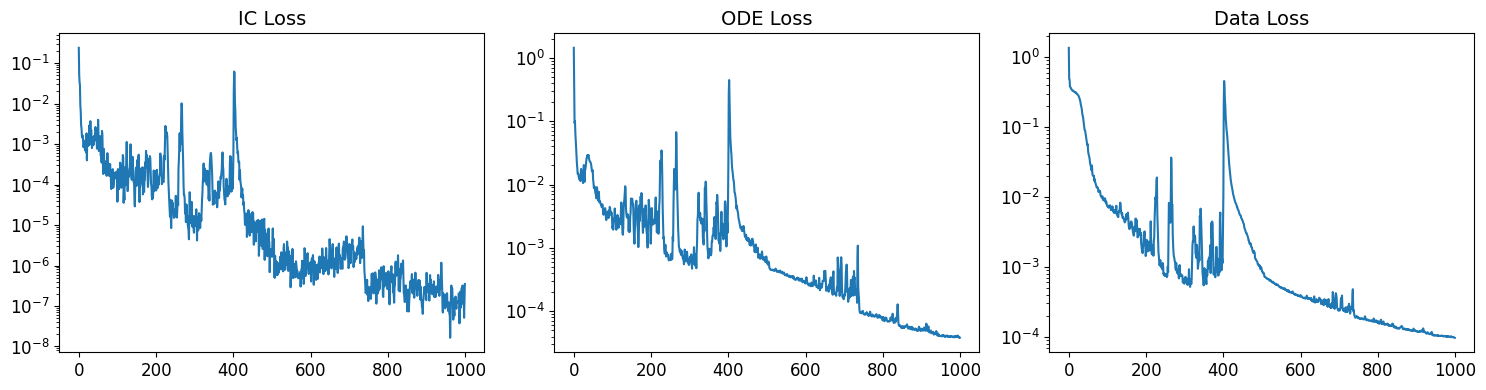

In [14]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

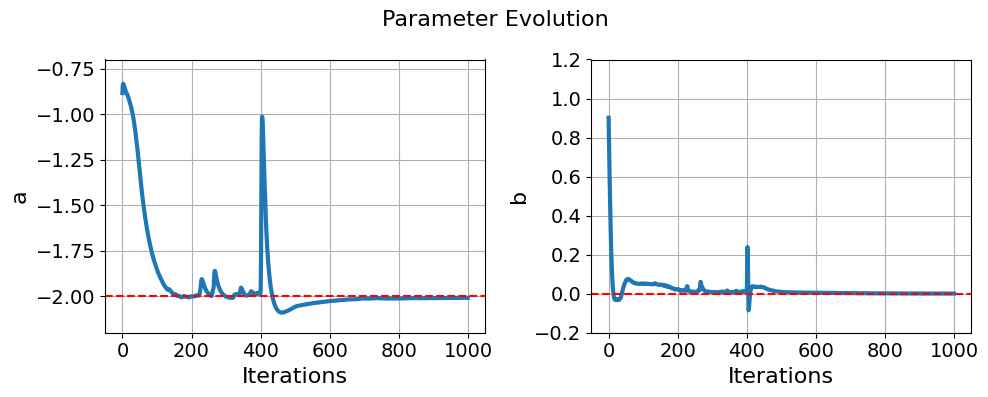

In [15]:
# Parameter history
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=-2, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN

In [16]:
t = np.linspace(0, 10, 10000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'f1': f[:, 0],
    'f2': f[:, 1]
})
df.to_csv('f_NN_IO.csv', index=False)

1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, 'f2')

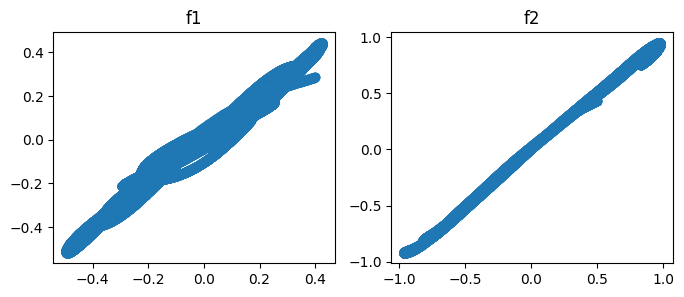

In [17]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [18]:
t = np.linspace(0, 10, 5000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

1/1 [==============================] - 0s 16ms/step


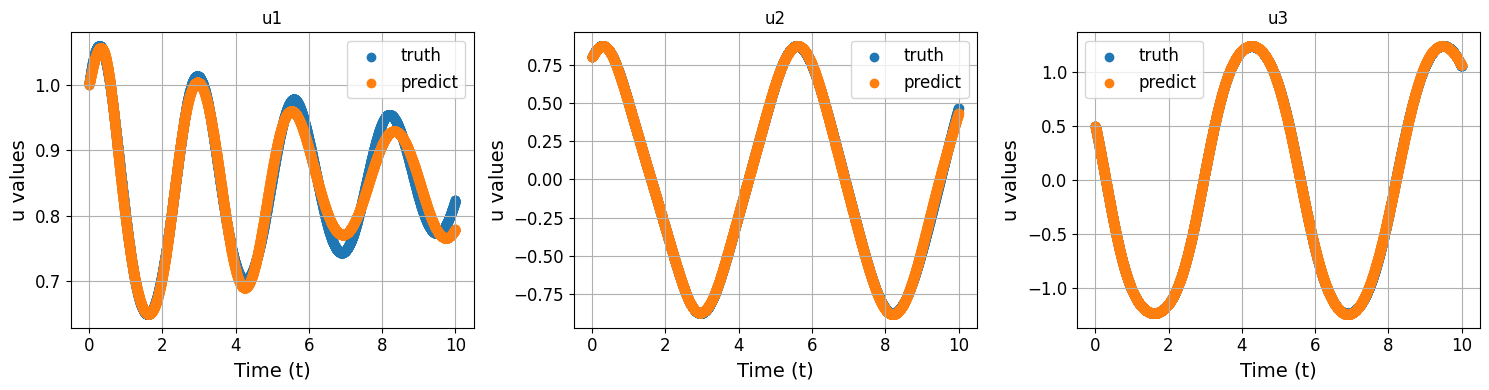

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 2], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 2], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [20]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

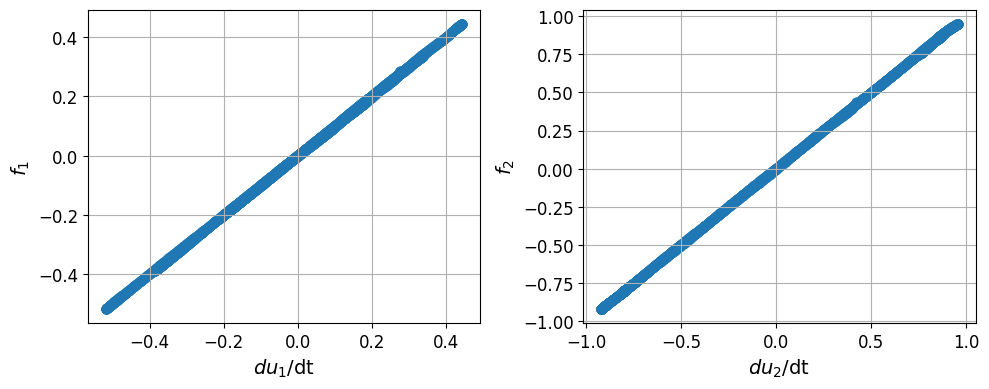

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()

# Symbolic Regression

In [22]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 7.0 MB/s eta 0:00:00


In [23]:
from pysr import PySRRegressor
import pandas as pd

# Load dataset
df = pd.read_csv('/content/f_NN_IO.csv')

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.8 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compa

In [24]:
df.head(10)

,t,u1,u2,u3,f1,f2
0,0.000000,1.000132,0.799583,0.500027,0.286791,0.435984
1,0.001000,1.000408,0.800005,0.498428,0.286328,0.435140
2,0.002000,1.000683,0.800426,0.496827,0.285865,0.434295
3,0.003000,1.000959,0.800847,0.495225,0.285403,0.433448
4,0.004000,1.001234,0.801268,0.493622,0.284941,0.432600
5,0.005001,1.001509,0.801689,0.492016,0.284479,0.431752
6,0.006001,1.001785,0.802110,0.490409,0.284017,0.430901
7,0.007001,1.002060,0.802530,0.488800,0.283556,0.430049
8,0.008001,1.002335,0.802950,0.487189,0.283095,0.429195
9,0.009001,1.002610,0.803370,0.485577,0.282634,0.428340


In [25]:
# Symbolic regression model
model = PySRRegressor(
    niterations=20,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    loss="L1DistLoss()",
    model_selection="score",
    complexity_of_operators={
        "sin": 3, "cos": 3, "exp": 3,
        "inv(x) = 1/x": 3
    }
)

# NN for f1
X = df.iloc[:, :4].to_numpy()
f1 = df.loc[:, 'f1'].to_numpy()

model.fit(X, f1)

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1015: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 7.770e+01
Progress: 1 / 620 total iterations (0.161%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
3           1.914e-01  5.314e+00  y = -0.61045 * 0.047716
6           1.914e-01  1.987e-08  y = -0.61045 * sin(0.047716)
8           1.912e-01  6.589e-04  y = -0.61045 * sin(0.047716 * x₃)
10          1.250e-01  2.123e-01  y = (0.67016 * x₂) * sin(x₃ + x₃)
12          7.897e-02  2.298e-01  y = 0.67016 * sin(x₂ * ((0.047716 * -0.95277) + x₃))
15          7.704e-02  8.268e-03  y = 0.67016 * (((0.047716 * sin(-0.95277)) + x₃) * sin(x₂)...
                                      )
16          7.649e-02  7.082e-03  y = sin((sin(sin(x₂)) * 0.67016) * (x₃ + -0.03889))
20          7.580e-02  2.280e-03  y = ((sin(x₀ * x₃) * 0.06131) + x₃) * sin(sin(x₂) * 0.6474...
     

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.914e-01  1.594e+01  y = -0.029407
3           1.469e-01  1.325e-01  y = x₃ * x₂
5           7.799e-02  3.165e-01  y = x₂ * (x₃ * 0.5918)
7           7.761e-02  2.427e-03  y = (x₂ * (x₃ + -0.014401)) * 0.6068
8           7.699e-02  8.028e-03  y = (cos(x₁) * x₃) * x₂
9           3.179e-02  8.845e-01  y = ((x₀ * (x₃ * -0.088319)) + x₃) * x₂
11          3.170e-02  1.385e-03  y = x₂ * ((x₃ + ((x₀ * x₃) * -0.087176)) * 0.98224)
12          3.135e-02  1.113e-02  y = (((x₀ * x₃) * -0.082884) + x₃) * sin(x₂)
14          3.071e-02  1.040e-02  y = sin(x₂ * 1.0563) * (x₃ + ((x₀ * -0.086674) * x₃))
16          2.991e-02  1.309e-02  y = sin(x₂) * (x₃ + (x₃ * (((x₃ * -0.59229) + x₀) * -0.087...
                                      27)))
17          2.893e-02  3.342e-02  y = ((x₃ * ((((x₃ + x₃) * -0.27098) + x₀) * -0.088034)) + ...
              

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.029406559   
	1         0.132515                                            x3 * x2   
	2         0.316510                              x2 * (x3 * 0.5918041)   
	3         0.002427             (x2 * (x3 + -0.014401063)) * 0.6068039   
	4         0.008028                                (cos(x1) * x3) * x2   
	5   >>>>  0.884483              ((x0 * (x3 * -0.08831884)) + x3) * x2   
	6         0.001385  x2 * ((x3 + ((x0 * x3) * -0.08717622)) * 0.982...   
	7         0.011131        (((x0 * x3) * -0.082884364) + x3) * sin(x2)   
	8         0.010403  sin(x2 * 1.0562658) * (x3 + ((x0 * -0.08667406...   
	9         0.013095  sin(x2) * (x3 + (x3 * (((x3 * -0.5922913) + x0...   
	10        0.033420  ((x3 * ((((x3 + x3) * -0.27098113) + x0) * -0....   
	11        0.072457  (((x0 + (x3 * -0.6074718)) * (x3 * -0.08763755...   
	12        0.002679  sin(x2 * 1.0915028) * (((x0 + ((x2 + 2.5771866...   
	13        0.007184  sin(x2 * 1.0750961) * ((((x0 + ((x3 + ((x0 + x...   
	
	        loss  complexity  
	0   0.191439           1  
	1   0.146869           3  
	2   0.077985           5  
	3   0.077607           7  
	4   0.076987           8  
	5   0.031790           9  
	6   0.031702          11  
	7   0.031351          12  
	8   0.030706          14  
	9   0.029912          16  
	10  0.028929          17  
	11  0.026907          18  
	12  0.026620          22  
	13  0.025866          26  
]

  - outputs/20250306_142619_vJBXBn/hall_of_fame.csv


In [26]:
X = df.iloc[:, :4].to_numpy()
f2 = df.loc[:, 'f2'].to_numpy()

model.fit(X, f2)

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2191: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.930e+03
Progress: 23 / 620 total iterations (3.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.600e-01  1.594e+01  y = -0.10632
3           1.799e-02  1.801e+00  y = x₁ * x₃
5           1.775e-02  6.744e-03  y = (x₁ * x₃) * 0.99511
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.980e+03
Progress: 61 / 620 total iterations (9.839%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x3   
	1   >>>>  1.128524                                            x1 * x3   
	2         0.007137                           (x1 + -0.003814591) * x3   
	3         0.010266                   ((x0 * -0.0009060358) + x1) * x3   
	4         0.014650           (x1 + (x0 * (x0 * -0.00036561734))) * x3   
	5         0.000314      (((x3 * x0) * (x2 * -0.005105762)) + x3) * x1   
	6         0.092285     (x1 * sin(x3 * 0.84218925)) + (x3 * 0.2034973)   
	7         0.000077  x1 * (cos((x3 * -0.028669931) * x0) * (x3 * 1....   
	8         0.033228  (cos(cos(x0) * ((x3 + x2) * 0.2703445)) * x1) ...   
	9         0.054446  (x1 * 1.0150492) * (x3 * cos((x2 + x3) * (cos(...   
	10        0.035746  cos(x3 * (((x3 + x2) * 0.26803496) * cos(x0)))...   
	11        0.000551  ((cos(((cos(x0) * x3) * -0.25609857) * (x3 + x...   
	12        0.003232  cos(((x3 + x2) * (sin(x3) * (cos(x0) * 0.34222...   
	13        0.024705  x1 * ((cos((cos(x0) * 0.33164272) * ((x2 * 0.5...   
	14        0.004613  ((x1 * x3) * cos(cos(x0) * (0.33164272 * (((x2...   
	
	        loss  complexity  
	0   0.171872           1  
	1   0.017988           3  
	2   0.017733           5  
	3   0.017373           7  
	4   0.016871           9  
	5   0.016860          11  
	6   0.015374          12  
	7   0.015372          14  
	8   0.013913          17  
	9   0.012478          19  
	10  0.011617          21  
	11  0.011604          23  
	12  0.011492          26  
	13  0.010938          28  
	14  0.010838          30  
]

  - outputs/20250306_142743_Cno06b/hall_of_fame.csv
